# Operator Inference with Optimization for Burger's Equation

Here we implment the operator inference solved with a non-constrained optimization approach rather than a linear least square approach shown in notebook 02. This is the reproduction of the results from [Peherstorfer and Willcox](https://www.sciencedirect.com/science/article/pii/S0045782516301104?via%3Dihub).

## Packages

In [1]:
using DataFrames
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Statistics
using NaNStatistics

## Initial Setup

In [2]:
include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

Main.LiftAndLearn

In [3]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.1, 1.0],
    2^(-7), 1e-4, 10, "dirichlet"
);

## Non-Constrained Optimization

In [5]:
num_inputs = 10
rmax = 15

options = LnL.NC_options(
    system=LnL.sys_struct(
        is_lin=true,
        is_quad=true,
        has_control=true,
        has_output=true,
    ),
    vars=LnL.vars(
        N=1,
    ),
    data=LnL.data(
        Δt=1e-4,
        deriv_type="SI",
        DS=100,
    ),
    optim=LnL.opt_settings(
        verbose=true,
        initial_guess=false,
    ),
)
Utest = ones(burger.Tdim - 1, 1);  # Reference input/boundary condition for OpInf testing 

# Error Values 
k = 3
proj_err = zeros(rmax - k, burger.Pdim)
intru_state_err = zeros(rmax - k, burger.Pdim)
opinf_state_err = zeros(rmax - k, burger.Pdim)
intru_output_err = zeros(rmax - k, burger.Pdim)
opinf_output_err = zeros(rmax - k, burger.Pdim)

# Downsampling rate
DS = options.data.DS

println("[INFO] Compute inferred and intrusive operators and calculate the errors")
for i in 1:length(burger.μs)
    μ = burger.μs[i]

    ## Create testing data
    A, B, F = burger.generateABFmatrix(burger, μ)
    C = ones(1, burger.Xdim) / burger.Xdim
    Xtest = LnL.semiImplicitEuler(A, B, F, Utest, burger.t, burger.IC)
    Ytest = C * Xtest

    op_burger = LnL.operators(A=A, B=B, C=C, F=F)

    ## training data for inferred dynamical models
    Urand = rand(burger.Tdim - 1, num_inputs)
    Xall = Vector{Matrix{Float64}}(undef, num_inputs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_inputs)
    for j in 1:num_inputs
        states = burger.semiImplicitEuler(A, B, F, Urand[:, j], burger.t, burger.IC)
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    X = reduce(hcat, Xall)
    R = reduce(hcat, Xdotall)
    Urand = Urand[1:DS:end, :]  # downsample data
    U = vec(Urand)[:,:]  # vectorize
    Y = C * X
    
    # compute the POD basis from the training data
    tmp = svd(X)
    Vrmax = tmp.U[:, 1:rmax]

    # Compute the values for the intrusive model from the basis of the training data
    op_int = LnL.intrusiveMR(op_burger, Vrmax, options)

    # Compute the inferred operators from the training data
    if options.optim.reproject
        op_inf = LnL.inferOp(X, U, Y, Vrmax, op_burger, options, op_int)  # Using Reprojection and Initial Guess
    else
        op_inf = LnL.inferOp(X, U, Y, Vrmax, Vrmax' * R, options, op_int)  # without reprojection but with initial guess
    end

    for j = 1+k:rmax
        Vr = Vrmax[:, 1:j]  # basis
        
        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, j)
        Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], op_int.B[1:j, :], Fint_extract, Utest, burger.t, Vr' * burger.IC)  # use F
        Yint = op_int.C[1:1, 1:j] * Xint
        
        # Integrate the inferred model
        Finf_extract = LnL.extractF(op_inf.F, j)
        Xinf = burger.semiImplicitEuler(op_inf.A[1:j, 1:j], op_inf.B[1:j, :], Finf_extract, Utest, burger.t, Vr' * burger.IC)  # use F
        Yinf = op_inf.C[1:1, 1:j] * Xinf

        # Compute errors
        PE, ISE, IOE, OSE, OOE = LnL.compError(Xtest, Ytest, Xint, Yint, Xinf, Yinf, Vr)

        # Sum of error values
        proj_err[j-k, i] = PE
        intru_state_err[j-k, i] = ISE
        intru_output_err[j-k, i] = IOE
        opinf_state_err[j-k, i] = OSE
        opinf_output_err[j-k, i] = OOE
    end
end

[INFO] Compute inferred and intrusive operators and calculate the errors


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.10700011253356934
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 5.614937340575066e9
│ objective_value      = 423.5547521667093
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:254
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:256
┌ Info: 
│ 
│ Output O

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1346777e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.0559999942779541
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.134677659576305e9
│ objective_value      = 544.2900044056756
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244
┌ Info: Done.
└ @ Main.Li

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.3029437e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.029999971389770508
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.302943699318736e9
│ objective_value      = 596.4253652748938
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9557822e-27 0.00e+00 1.14e-11  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:254
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:256
┌ Info: 
│ 
│ Output Optimization
│ Warm Start           = False
│ order                = 15
│ solve time           = 0.0
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 3.955782168474807e-27
│ objective_value      = 3.955782168474807e-27
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:258
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:271


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5237221e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.056999921798706055
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.523722112173977e9
│ objective_value      = 652.964517018464
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244
┌ Info: Done.
└ @ Main.L

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1426700e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.03900003433227539
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.14266996293722e9
│ objective_value      = 637.3902576629
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.4275103e-28 0.00e+00 5.38e-12  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:254
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:256
┌ Info: 
│ 
│ Output Optimization
│ Warm Start           = False
│ order                = 15
│ solve time           = 0.0009999275207519531
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 7.427510328443585e-28
│ objective_value      = 7.427510328443585e-28
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:258
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:271


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.3465403e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.019999980926513672
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.346540345593609e9
│ objective_value      = 621.3230335123642
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244
┌ Info: Done.
└ @ Main.

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:271


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.2677774e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.005000114440917969
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.267777419041844e9
│ objective_value      = 564.7920434923946
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optim

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.6203420e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.029999971389770508
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 6.620341961841087e9
│ objective_value      = 550.3375844769703
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244
┌ Info: Done.
└ @ Main.

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3186133e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.06299996376037598
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 7.318613278737168e9
│ objective_value      = 535.2515705937187
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.5594461e-26 0.00e+00 4.63e-11  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:254
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:256
┌ Info: 
│ 
│ Output Optimization
│ Warm Start           = False
│ order                = 15
│ solve time           = 0.0009999275207519531
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 5.55944610640709e-26
│ objective_value      = 5.55944610640709e-26
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:258
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:271


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:23


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139740

Total number of variables............................:     2040
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.5751440e+09 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:81
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:84
┌ Info: 
│ 
│ Constraint           = Non-Constrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.012
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.039999961853027344
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 7.575144035662266e9
│ objective_value      = 463.00212024448757
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:86
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:107
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:244


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5658330e-28 0.00e+00 3.04e-12  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:254
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:256
┌ Info: 
│ 
│ Output Optimization
│ Warm Start           = False
│ order                = 15
│ solve time           = 0.0
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 4.56583301882046e-28
│ objective_value      = 4.56583301882046e-28
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:258
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NC_Optimize.jl:271


## Results

In [6]:
proj_err_mean = nanmean(proj_err, dims=2)
intru_state_err_mean = nanmean(intru_state_err, dims=2)
intru_output_err_mean = nanmean(intru_output_err, dims=2)
opinf_state_err_mean = nanmean(opinf_state_err, dims=2)
opinf_output_err_mean = nanmean(opinf_output_err, dims=2)

df = DataFrame(
    order=1+k:rmax,
    projection_err=vec(proj_err_mean),
    intrusive_state_err=vec(intru_state_err_mean),
    intrusive_output_err=vec(intru_output_err_mean),
    inferred_state_err=vec(opinf_state_err_mean),
    inferred_output_err=vec(opinf_output_err_mean)
)

Row,order,projection_err,intrusive_state_err,intrusive_output_err,inferred_state_err,inferred_output_err
,Int64,Float64,Float64,Float64,Float64,Float64
1,4,0.00921576,0.0135497,0.375139,0.0134583,1.0
2,5,0.00460681,0.00660266,0.366729,0.00656958,1.0
3,6,0.00213087,0.00300243,0.36391,0.00305458,1.0
4,7,0.00102748,0.00140824,0.362755,0.00156192,1.0
5,8,0.000491753,0.000665027,0.362032,0.000937313,1.0
6,9,0.000227089,0.000301279,0.360505,0.000708902,1.0
7,10,0.000108174,0.000140889,0.356988,0.000640115,1.0
8,11,5.25635e-5,6.62221e-5,0.351791,0.00061887,1.0
9,12,2.52804e-5,3.2235e-5,0.346604,0.000606,1.0


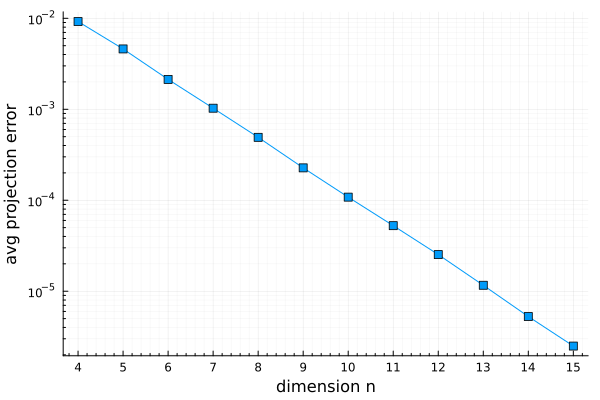

In [7]:
# Projection error
plot(df.order, df.projection_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(df.projection_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg projection error")

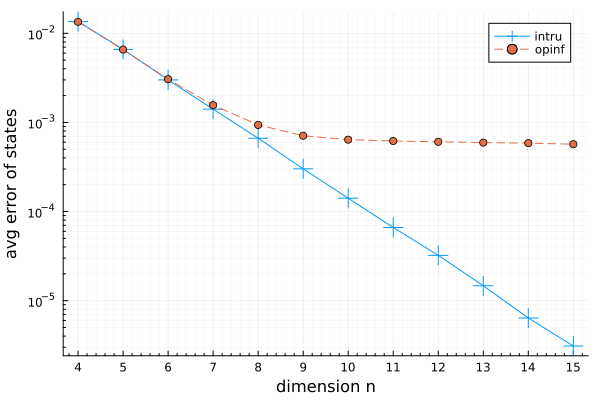

In [8]:
# State errors
plot(df.order, df.intrusive_state_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)

yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of states")

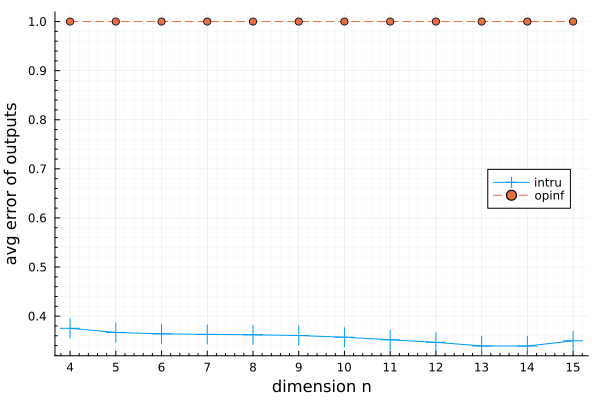

In [9]:
# Output errors
plot(df.order, df.intrusive_output_err, marker=(:cross, 10), label="intru")
plot!(df.order, df.inferred_output_err, marker=(:circle), ls=:dash, label="opinf")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xticks!(df.order)
xlabel!("dimension n")
ylabel!("avg error of outputs")

In [10]:
tmp1 = DataFrame([4:rmax], [:order])
tmp2 = DataFrame(opinf_state_err, :auto)
df2 = hcat(tmp1, tmp2)
rename!(
    df2,
    [:x1,:x2,:x3,:x4,:x5,:x6,:x7,:x8,:x9,:x10] .=> Symbol.(burger.μs)
)

Row,order,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,4,0.030473,0.0189477,0.0162473,0.0134441,0.0114918,0.0109664,0.0095989,0.0083765,0.00780078,0.00723659
2,5,0.0190919,0.00833746,0.00680513,0.0059266,0.00549797,0.00492504,0.00429527,0.00384209,0.00352735,0.00344691
3,6,0.0105359,0.00452044,0.00295465,0.00244072,0.0020529,0.00187222,0.00167582,0.00161061,0.00153149,0.00135097
4,7,0.00710428,0.00198179,0.00148604,0.00111519,0.000855399,0.000727737,0.000712863,0.000590986,0.000590289,0.000454619
5,8,0.00519008,0.00103875,0.000762468,0.000542936,0.000433891,0.000293858,0.000354935,0.000211354,0.000231264,0.000313604
6,9,0.00439425,0.000608792,0.000595121,0.000306653,0.000232493,0.000148477,0.000295203,0.000139533,0.000237084,0.000131416
7,10,0.00412579,0.000440511,0.000549357,0.000279465,0.000192974,9.54548e-5,0.000287104,0.000120046,0.000109708,0.000200738
8,11,0.00397601,0.000420847,0.000543814,0.000277533,0.000186476,9.31937e-5,0.000283709,0.000118973,0.000106035,0.000182116
9,12,0.00388737,0.000405318,0.00054204,0.000273118,0.00018827,8.68186e-5,0.000278977,0.000110972,9.38255e-5,0.000193288


The NaN for r=15 and $\mu$=1 is causing the dip for the last point. Also, we can see that for $\mu$=1,2 where the diffusion is small, the relative state errors are higher.